## 01.04.2019

## Part 1: Winter
### Parsing the information:

In [1]:
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import datetime

#### Open files:

In [2]:
filenames = ['./2010_December/kanz_bband_fd_20101204_1339.fts', './2010_December/kanz_bband_fd_20101205_1111.fts', './2010_December/kanz_bband_fd_20101206_0936.fts'
            , './2010_December/kanz_bband_fd_20101207_1255.fts', './2010_December/kanz_bband_fd_20101208_0814.fts', './2010_December/kanz_bband_fd_20101209_1312.fts'
            , './2010_December/kanz_bband_fd_20101210_1102.fts', './2010_December/kanz_bband_fd_20101211_1008.fts']

In [3]:
data = []
for fn in filenames:
    data.append((fits.open(fn))[0])

In [4]:
img = []
timestamp = []
radius = []

#### Rotate the images by %ANGLE% and flip it; <br>
#### Get timestamp from %DATE-OBS%

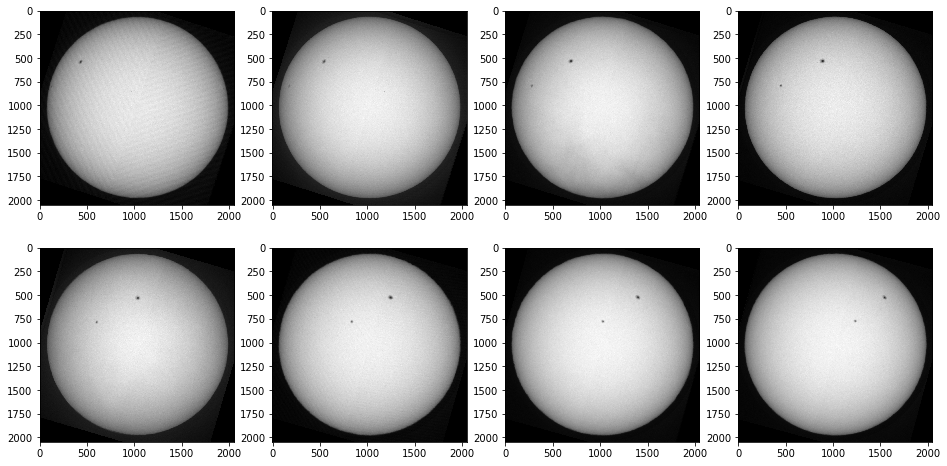

In [5]:
plt.figure(figsize=(16, 8))
for i in range(len(data)):
    plt.subplot(2, 4, i+1)
    tmp = Image.fromarray(data[i].data)
    tmp = tmp.rotate(data[i].header['ANGLE'])
    radius.append(data[i].header['SOLAR_R'])
    timestamp.append(datetime.datetime.strptime(data[i].header['DATE-OBS'], '%Y-%m-%dT%H:%M:%S'))
    tmp = np.flipud(tmp)
    img.append(tmp)
    plt.imshow(tmp, cmap='gray')
    

### Image processing:
#### Prepearing the images for OpenCV format:

In [6]:
img_8 = []

In [7]:
for i in img:
    img_8.append((i/4).astype('uint8'))

In [8]:
th = []

In [9]:
for i in img_8:
    tmp = cv2.adaptiveThreshold(i, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 75, 11)
    th.append(tmp)

#### Сonduct threshold analysis:

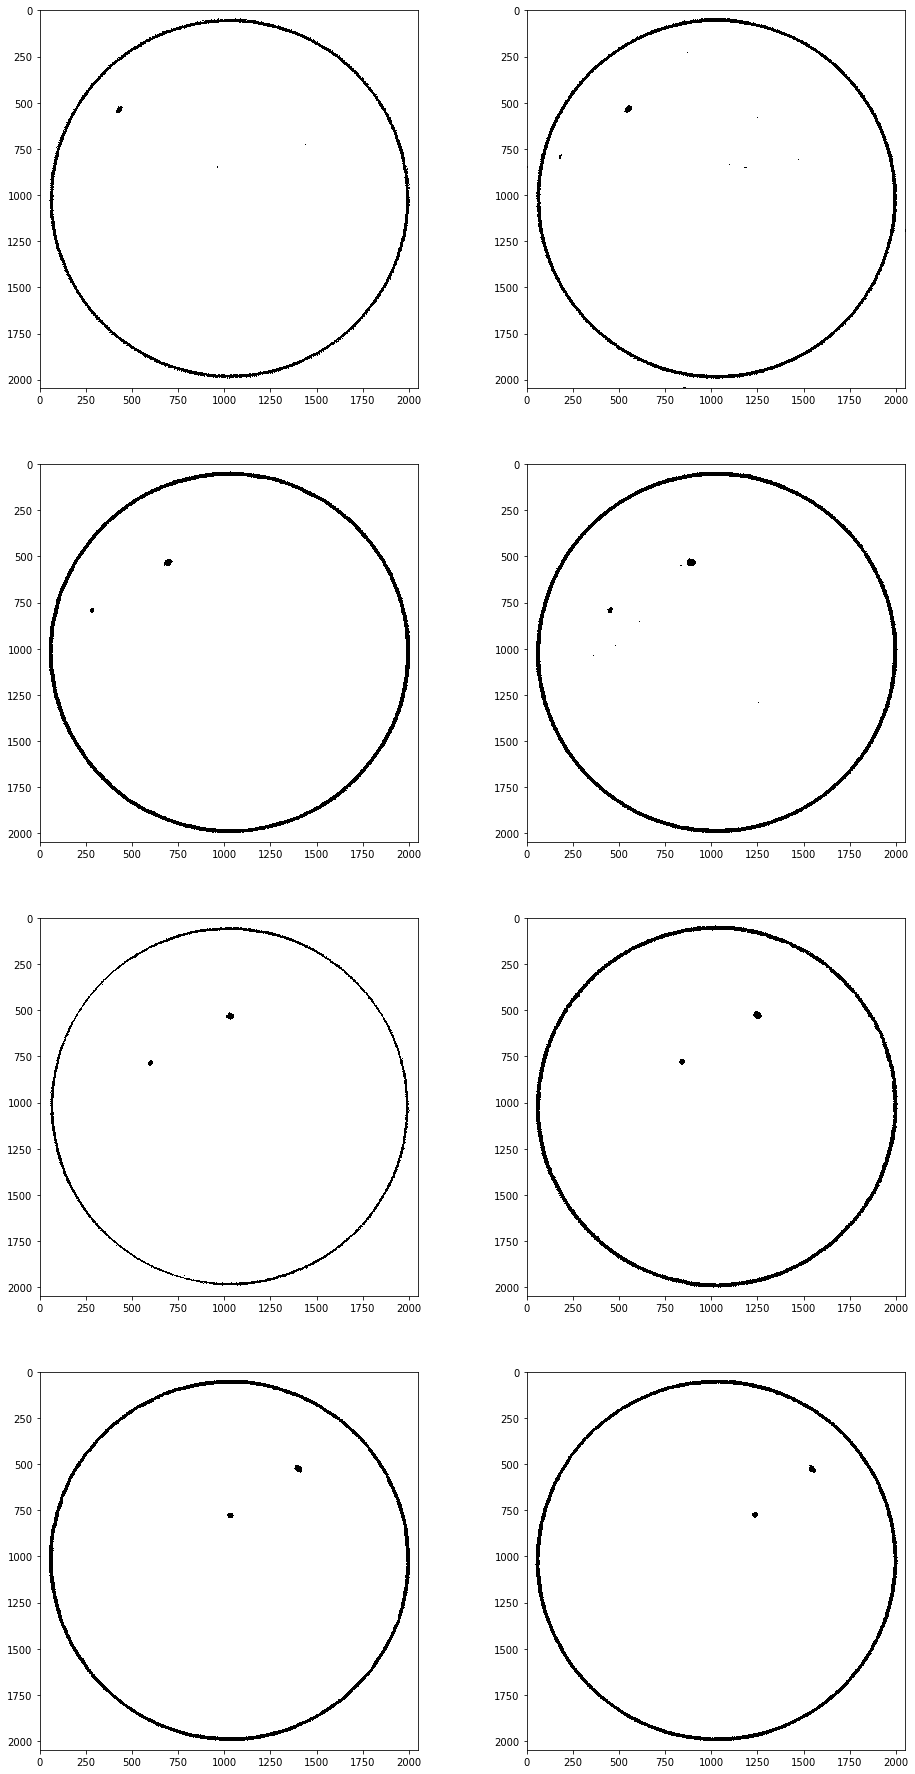

In [10]:
plt.figure(figsize=(16, 32))
for i in range(len(data)):
    plt.subplot(4, 2, i+1)
    plt.imshow(th[i], cmap='gray')

<b> In these images, we see the boundaries of the sun, spots that need to be recognized and some noise.<br>
Let's filter them by size (noise points are too small, the Sun is too big) </b>

In [11]:
cont_all = []
points_all = []

In [12]:
for i in th:
    contours, hierarch = cv2.findContours(i, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    realcont = []
    points = []
    lat = []
    longt = []
    for cont in contours:
        m = cv2.moments(cont)
        if (m['m00'] > 200)&(m['m00'] < 1000000):
            realcont.append(cont)
            points.append((m['m10']/m['m00'], m['m01']/m['m00']))
    cont_all.append(realcont)
    points_all.append(points)

<b> Using the moments of the images we find the location of the center of the spot. Check the correctness of the algorithm by displaying the recognized spots on the original images: </b>

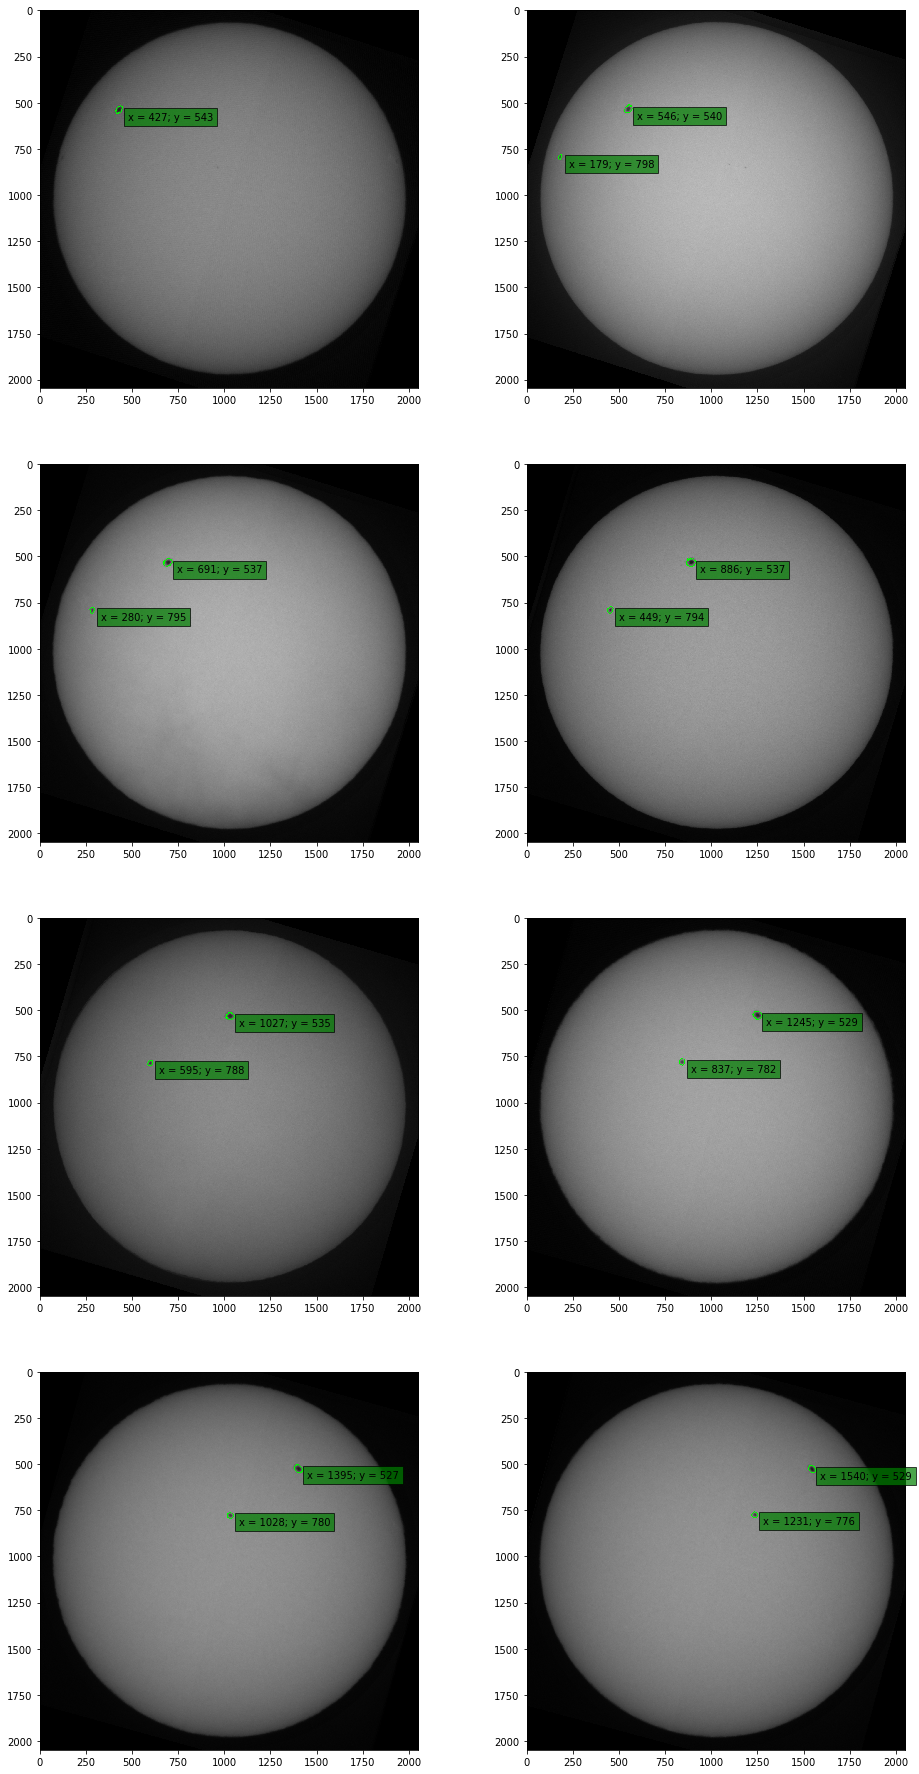

In [13]:
plt.figure(figsize=(16, 32))
for i in range(len(img_8)):
    tmp = cv2.cvtColor(img_8[i].copy(), cv2.COLOR_GRAY2BGR)
    tmp = cv2.drawContours(tmp, cont_all[i], -1, (0, 255, 0), 3)
    tmp = cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB)
    plt.subplot(4, 2, i+1)
    plt.imshow(tmp)
    for j in points_all[i]:
        txt = 'x = ' + str(int(j[0])) + '; y = ' + str(int(j[1]))
        plt.text(j[0]+50, j[1]+50, txt, bbox=dict(facecolor='green', alpha=0.7))

### From image to the physical model:

<b>Using the data from the methodological guide on the obtained coordinates, we determine the latitude and longitude of the spots.</b>

In [14]:
lat_all = []
longt_all = []
for i in range(len(points_all)):
    lat = []
    longt = []
    for j in range(len(points_all[i])):
        z = 1024-points_all[i][j][1]
        y = points_all[i][j][0] - 1024
        teta = np.arccos(z*1.0/radius[i])
        fi = np.arcsin(y/(radius[i]*np.sin(teta)))
        lat.append(np.pi/2-teta)
        longt.append(fi)
    lat_all.append(lat)
    longt_all.append(longt)

In [15]:
spot1_lat = []
spot2_lat = [lat_all[0][0]]
spot1_longt = []
spot2_longt = [longt_all[0][0]]
for i in range(1, len(lat_all)):
    spot1_lat.append(lat_all[i][0])
    spot2_lat.append(lat_all[i][1])
    spot1_longt.append(longt_all[i][0])
    spot2_longt.append(longt_all[i][1])

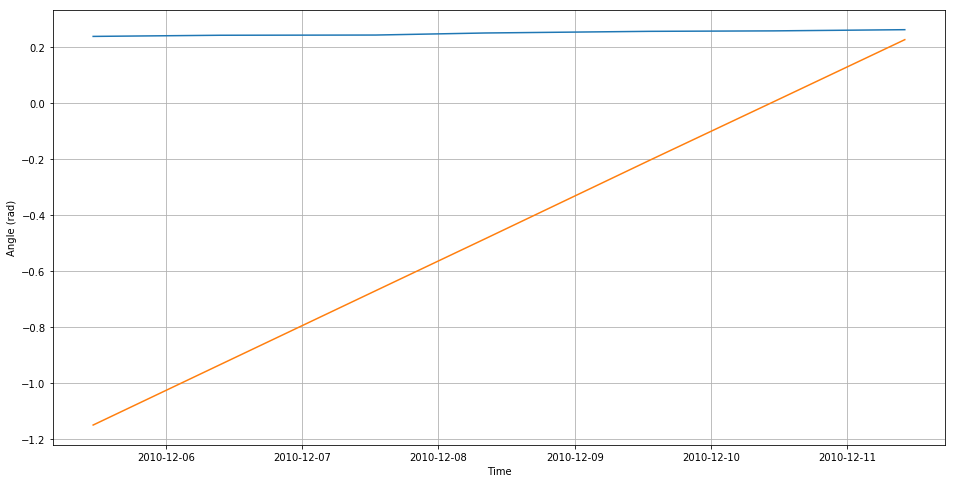

In [16]:
plt.figure(figsize=(16, 8))
plt.grid()
plt.xlabel('Time')
plt.ylabel('Angle (rad)')
plt.plot(timestamp[1:], spot1_lat)
plt.plot(timestamp[1:], spot1_longt)
plt.show()

<b>Above is a graph of the latitude and longitude of the first (lower) spot. According to the graphs we can judge that the image was rotated at the correct angle (the latitude practically does not change), and by the linear increase in longitude we can judge the constant speed of rotation of the spot.</b>

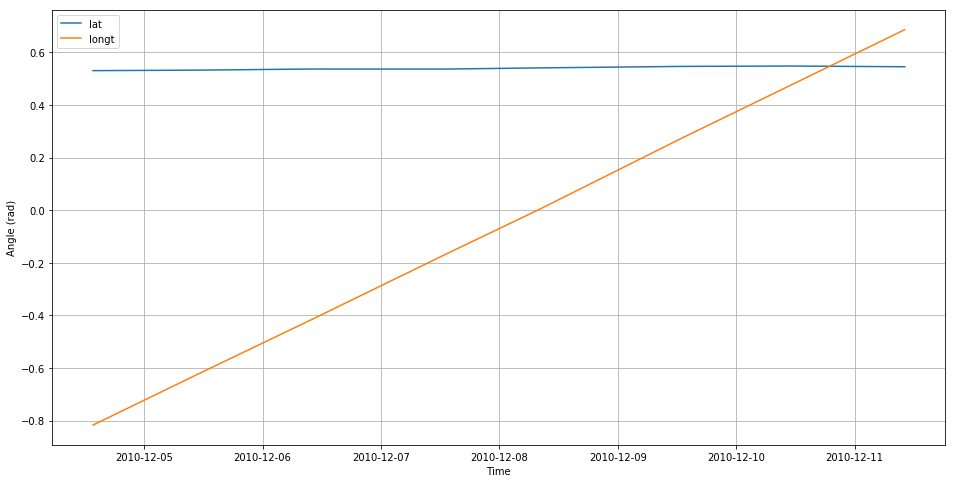

In [17]:
plt.figure(figsize=(16, 8))
plt.grid()
plt.xlabel('Time')
plt.ylabel('Angle (rad)')
plt.plot(timestamp, spot2_lat, label = 'lat')
plt.plot(timestamp, spot2_longt, label = 'longt')
plt.legend()
plt.show()

<b>Above is a graph of the change in latitude and longitude of the second (upper) spot. According to these graphs, we can also judge that the image was rotated at the correct angle (the latitude practically does not change), and by the linear increase in longitude we can judge the constant speed of rotation of the spot.</b>

<b>Now, having the position of the spots and the measurement time, we calculate the angular velocity of the spots relative to the ground:

In [18]:
dt = []
for i in range(1, len(timestamp)):
    dt.append((timestamp[i].hour-timestamp[i-1].hour+24)*1.0/24)
dt = np.array(dt)

In [19]:
dlongt1 = []
for i in range(1, len(spot1_longt)):
    dlongt1.append(spot1_longt[i]-spot1_longt[i-1])
dlongt1 = np.array(dlongt1)
dlongt2 = []
for i in range(1, len(spot2_longt)):
    dlongt2.append(spot2_longt[i]-spot2_longt[i-1])
dlongt2 = np.array(dlongt2)

In [20]:
omg1 = dlongt1/(dt[1:])
omg2 = dlongt2/dt

In [21]:
print 'Omega1 = ', round(np.average(omg1)*180/np.pi, 2), '±' ,  round(np.std(omg1)*180/np.pi, 2), 'deg/day'
print 'Omega2 =', round(np.average(omg2)*180/np.pi, 2), '±' ,  round(np.std(omg2)*180/np.pi, 2), 'deg/day'

Omega1 =  13.23 ± 0.24 deg/day
Omega2 = 12.5 ± 0.29 deg/day


<b>Now, following the methodological guide, we find our own angular velocity for each spot:

In [22]:
P1 = 2*np.pi/omg1
P2 = 2*np.pi/omg2

In [23]:
Psid1 = P1*356.2564/(P1 + 356.2564)
Psid2 = P2*356.2564/(P2 + 356.2564)

In [24]:
omgsid1 = 2*np.pi/Psid1
omgsid2 = 2*np.pi/Psid2

In [25]:
a = 14.55*np.pi/180
b = -2.87*np.pi/180

In [26]:
omgsid1ref = a + b * np.sin(spot1_lat)**2
omgsid2ref = a + b * np.sin(spot2_lat)**2

In [27]:
ref_x = np.array(range(-50, 50))*np.pi/180
ref_y = a + b * np.sin(ref_x)**2

In [28]:
print 'Omega1 = ', round(np.average(omgsid1)*180/np.pi, 2), '±' ,  round(np.std(omgsid1)*180/np.pi, 2), 'deg/day'
print 'Omega2 =', round(np.average(omgsid2)*180/np.pi, 2), '±' ,  round(np.std(omgsid2)*180/np.pi, 2), 'deg/day'

Omega1 =  14.24 ± 0.24 deg/day
Omega2 = 13.51 ± 0.29 deg/day


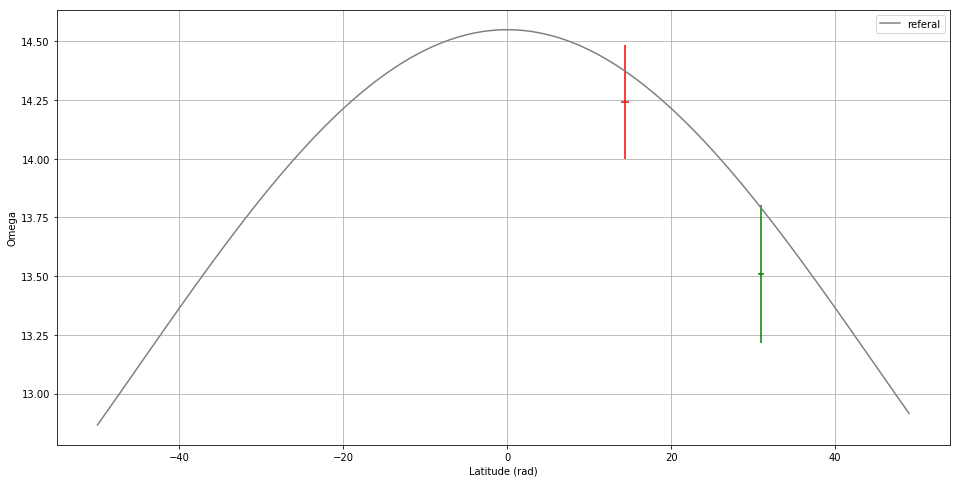

In [29]:
plt.figure(figsize=(16, 8))
plt.grid()
plt.xlabel('Latitude (rad)')
plt.ylabel('Omega')
plt.plot(ref_x*180/np.pi, ref_y*180/np.pi, label = 'referal', color = 'gray')
plt.errorbar(x = np.average(spot1_lat)*180/np.pi, y = np.average(omgsid1)*180/np.pi, xerr = np.std(spot1_lat)*180/np.pi, yerr = np.std(omgsid1)*180/np.pi, color = 'red')
plt.errorbar(x = np.average(spot2_lat)*180/np.pi, y = np.average(omgsid2)*180/np.pi, xerr = np.std(spot2_lat)*180/np.pi, yerr = np.std(omgsid2)*180/np.pi, color = 'green')
plt.legend()
plt.show()

<b>The obtained data are close to the previously obtained values, however, they have a rather large error.<br>Now let's take the same measurements, but for a different data set.

## Part 2: Summer
### Parsing the information:

#### Open files:

In [30]:
filenames = ['./2016_June/kanz_bband_fd_20160611_1141.fts', './2016_June/kanz_bband_fd_20160612_0942.fts',
            './2016_June/kanz_bband_fd_20160613_0632.fts', './2016_June/kanz_bband_fd_20160614_1113.fts', './2016_June/kanz_bband_fd_20160615_0729.fts',
            './2016_June/kanz_bband_fd_20160616_0739.fts', './2016_June/kanz_bband_fd_20160617_0613.fts', './2016_June/kanz_bband_fd_20160618_0559.fts',
            './2016_June/kanz_bband_fd_20160619_0731.fts', './2016_June/kanz_bband_fd_20160621_0629.fts']

In [31]:
data = []
for fn in filenames:
    data.append((fits.open(fn))[0])

In [32]:
img = []
timestamp = []
radius = []

#### Rotate the images by %ANGLE% and flip it; <br>
#### Get timestamp from %DATE-OBS%

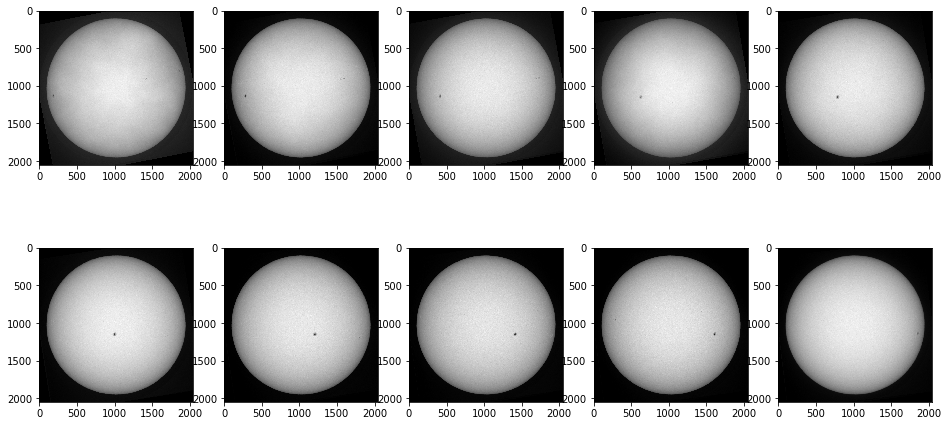

In [33]:
plt.figure(figsize=(16, 8))
for i in range(len(data)):
    plt.subplot(2, 5, i+1)
    tmp = Image.fromarray(data[i].data)
    tmp = tmp.rotate(data[i].header['ANGLE'])
    radius.append(data[i].header['SOLAR_R'])
    timestamp.append(datetime.datetime.strptime(data[i].header['DATE-OBS'], '%Y-%m-%dT%H:%M:%S'))
    tmp = np.flipud(tmp)
    img.append(tmp)
    plt.imshow(tmp, cmap='gray')
    

### Image processing:
#### Prepearing the images for OpenCV format:

In [34]:
img_8 = []

In [35]:
for i in img:
    img_8.append((i/16).astype('uint8'))

In [36]:
th = []

In [37]:
for i in img_8:
    tmp = cv2.adaptiveThreshold(i, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 75, 10)
    th.append(tmp)

#### Сonduct threshold analysis:

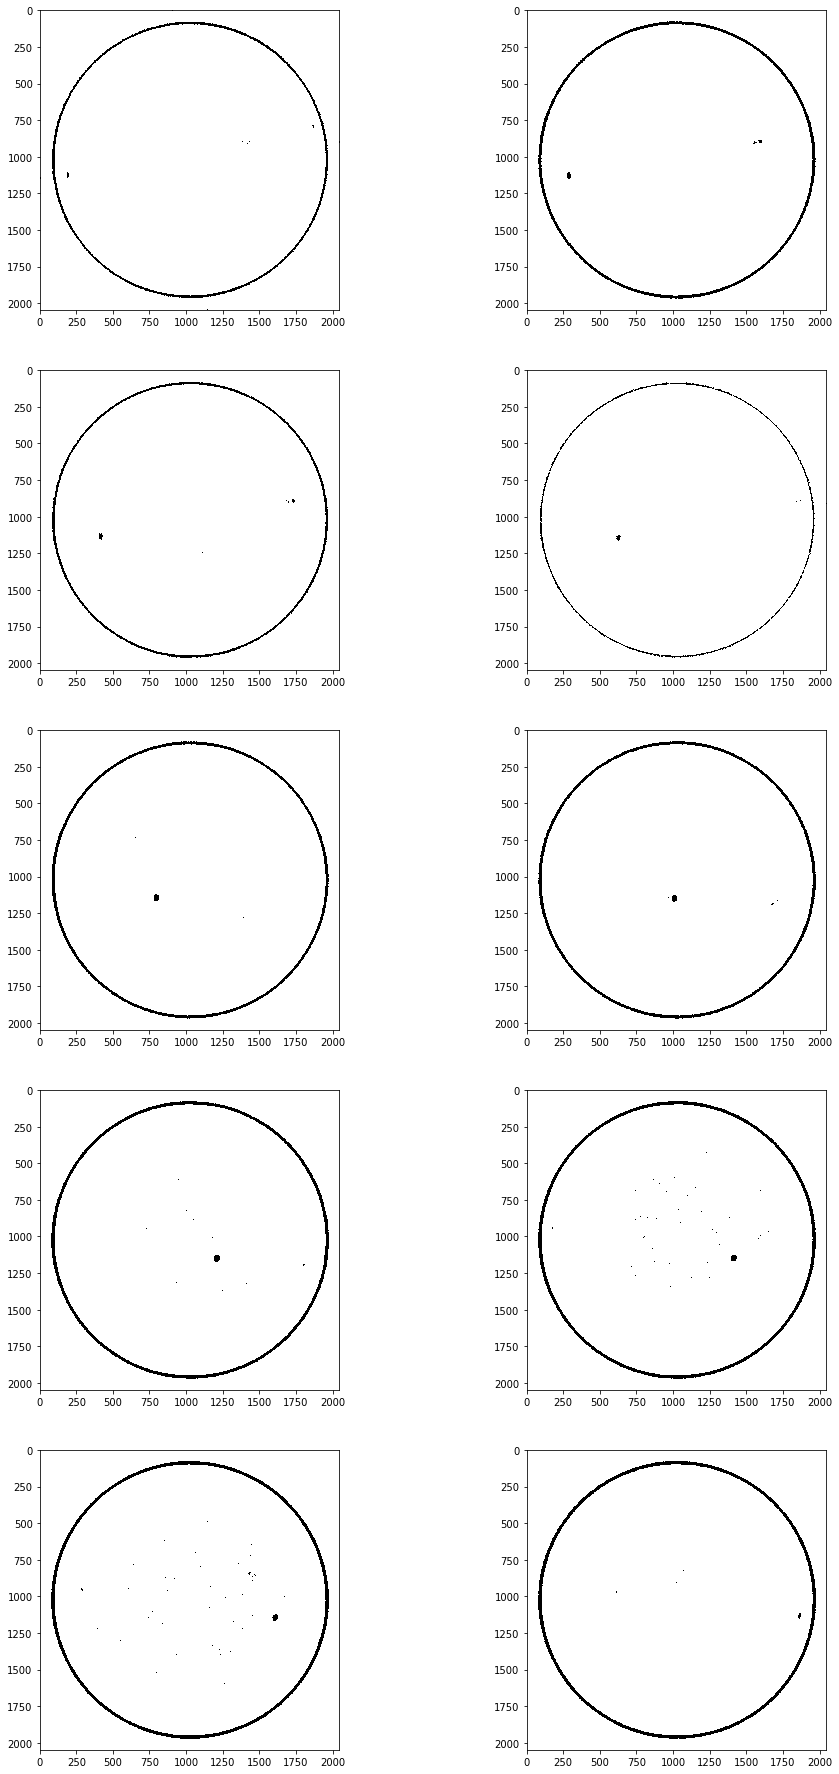

In [38]:
plt.figure(figsize=(16, 32))
for i in range(len(data)):
    plt.subplot(5, 2, i+1)
    plt.imshow(th[i], cmap='gray')

<b> In these images, we see the boundaries of the sun, spots that need to be recognized and some noise.<br>
Let's filter them by size (noise points are too small, the Sun is too big) </b>

In [39]:
cont_all = []
points_all = []

In [40]:
for i in th:
    contours, hierarch = cv2.findContours(i, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    realcont = []
    points = []
    lat = []
    longt = []
    for cont in contours:
        m = cv2.moments(cont)
        if (m['m00'] > 500)&(m['m00'] < 1000000):
            realcont.append(cont)
            points.append((m['m10']/m['m00'], m['m01']/m['m00']))
    cont_all.append(realcont)
    points_all.append(points)

<b> Using the moments of the images we find the location of the center of the spot. Check the correctness of the algorithm by displaying the recognized spots on the original images: </b>

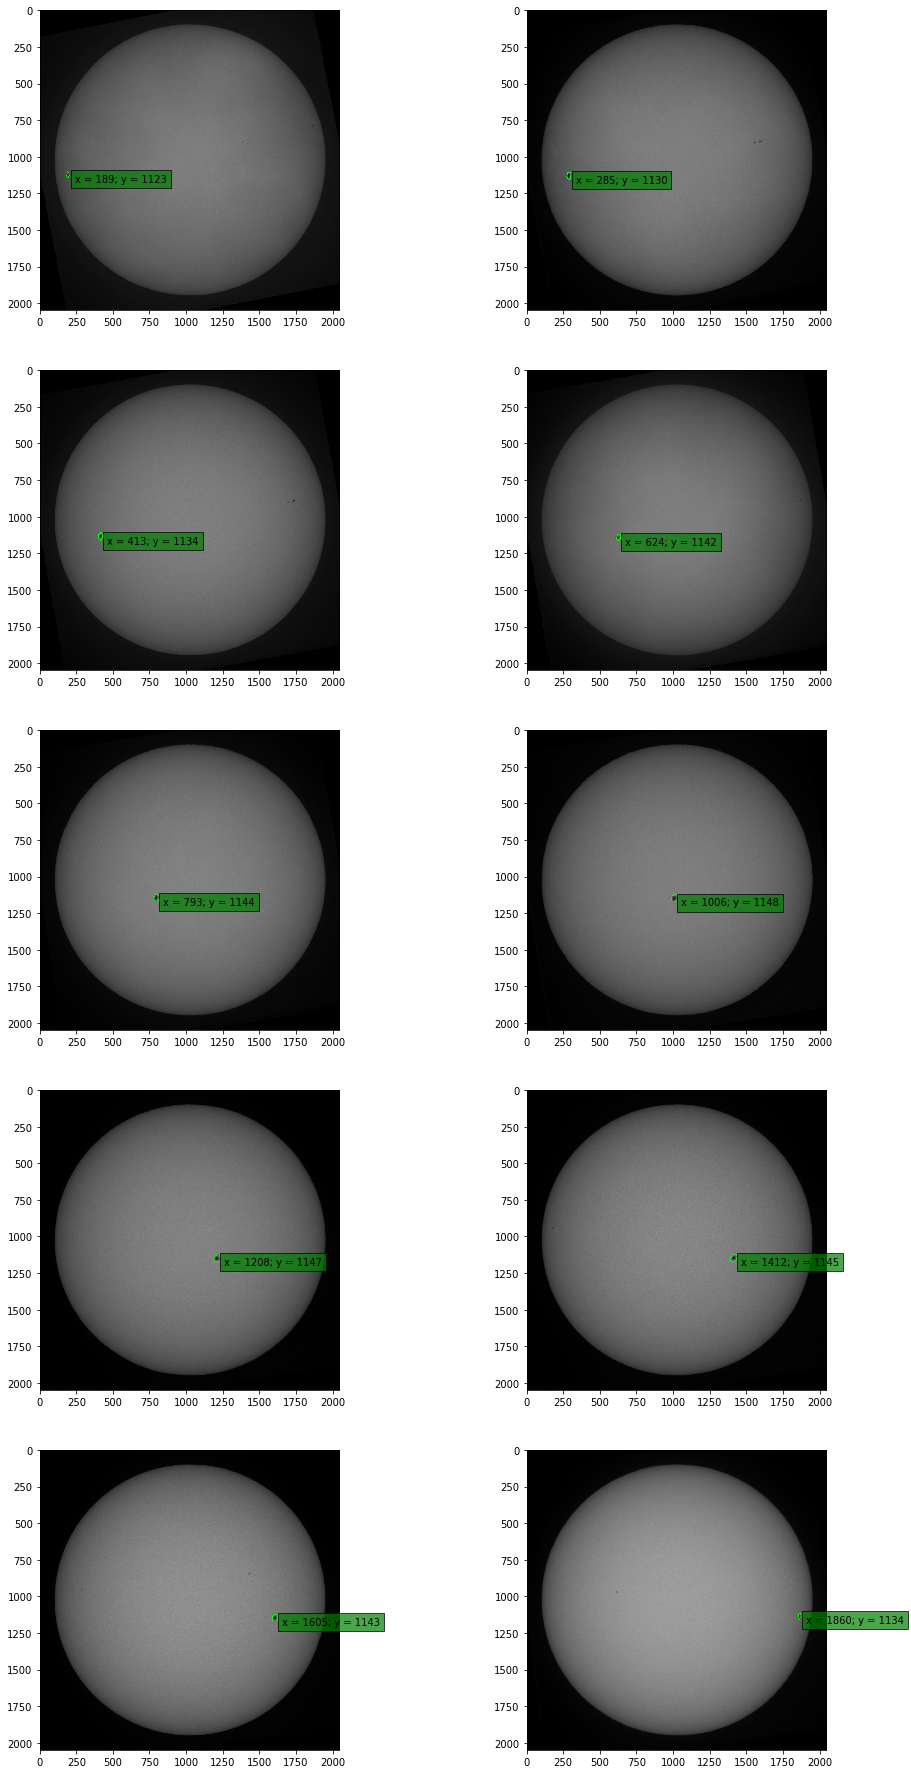

In [41]:
plt.figure(figsize=(16, 32))
for i in range(len(img_8)):
    tmp = cv2.cvtColor(img_8[i].copy(), cv2.COLOR_GRAY2BGR)
    tmp = cv2.drawContours(tmp, cont_all[i], -1, (0, 255, 0), 3)
    tmp = cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 2, i+1)
    plt.imshow(tmp)
    for j in points_all[i]:
        txt = 'x = ' + str(int(j[0])) + '; y = ' + str(int(j[1]))
        plt.text(j[0]+50, j[1]+50, txt, bbox=dict(facecolor='green', alpha=0.7))

### From image to the physical model:

<b>Using the data from the methodological guide on the obtained coordinates, we determine the latitude and longitude of the spots.</b>

In [42]:
lat_all = []
longt_all = []
for i in range(len(points_all)):
    lat = []
    longt = []
    for j in range(len(points_all[i])):
        z = 1024-points_all[i][j][1]
        y = points_all[i][j][0] - 1024
        teta = np.arccos(z*1.0/radius[i])
        fi = np.arcsin(y/(radius[i]*np.sin(teta)))
        lat.append(np.pi/2-teta)
        longt.append(fi)
    lat_all.append(lat)
    longt_all.append(longt)

In [43]:
spot3_lat = []
spot3_longt = []
for i in range(len(lat_all)):
    spot3_lat.append(lat_all[i][0])    
    spot3_longt.append(longt_all[i][0])

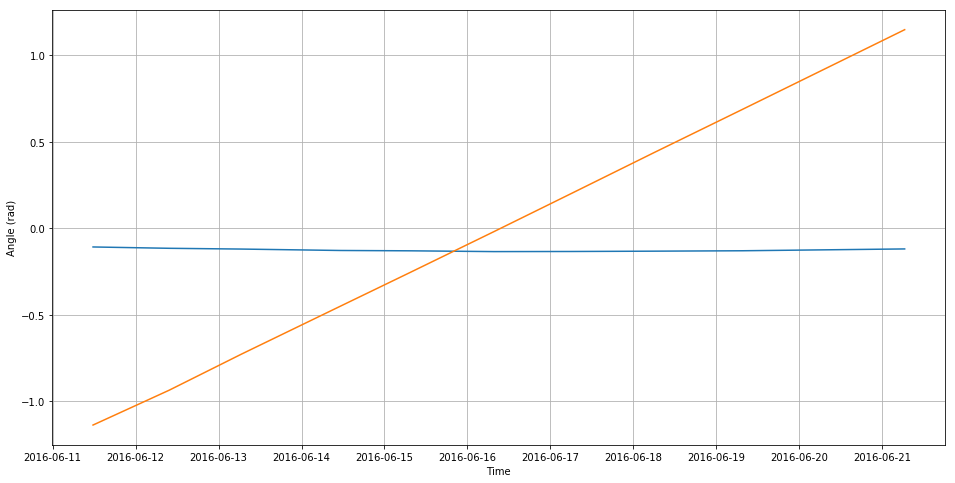

In [44]:
plt.figure(figsize=(16, 8))
plt.grid()
plt.xlabel('Time')
plt.ylabel('Angle (rad)')
plt.plot(timestamp, spot3_lat)
plt.plot(timestamp, spot3_longt)
plt.show()

<b>Above is a graph of the latitude and longitude of the third spot. According to the graphs we can judge that the image was rotated at the correct angle (the latitude practically does not change), and by the linear increase in longitude we can judge the constant speed of rotation of the spot.</b>

<b>Now, having the position of the spots and the measurement time, we calculate the angular velocity of the spots relative to the ground:

In [45]:
dt = []
for i in range(1, len(timestamp)):
    dt.append((timestamp[i].hour-timestamp[i-1].hour+24)*1.0/24)
dt = np.array(dt)

In [46]:
dlongt3 = []
for i in range(1, len(spot3_longt)):
    dlongt3.append(spot3_longt[i]-spot3_longt[i-1])
dlongt3 = np.array(dlongt3)

In [47]:
omg3 = dlongt3/dt

In [48]:
print 'Omega3 = ', round(np.average(omg3)*180/np.pi, 2), '±' ,  round(np.std(omg3)*180/np.pi, 2), 'deg/day'

Omega3 =  14.93 ± 4.48 deg/day


<b>Now, following the methodological guide, we find our own angular velocity for each spot:

In [49]:
P3 = 2*np.pi/omg3

In [50]:
Psid3 = P3*356.2564/(P3 + 356.2564)

In [51]:
omgsid3 = 2*np.pi/Psid3

In [52]:
a = 14.55*np.pi/180
b = -2.87*np.pi/180

In [53]:
omgsid3ref = a + b * np.sin(spot3_lat)**2

In [54]:
ref_x = np.array(range(-50, 50))*np.pi/180
ref_y = a + b * np.sin(ref_x)**2

In [55]:
print 'Omega3 = ', round(np.average(omgsid3[:-1])*180/np.pi, 2), '±' ,  round(np.std(omgsid3[:-1])*180/np.pi, 2), 'deg/day'

Omega3 =  14.36 ± 0.39 deg/day


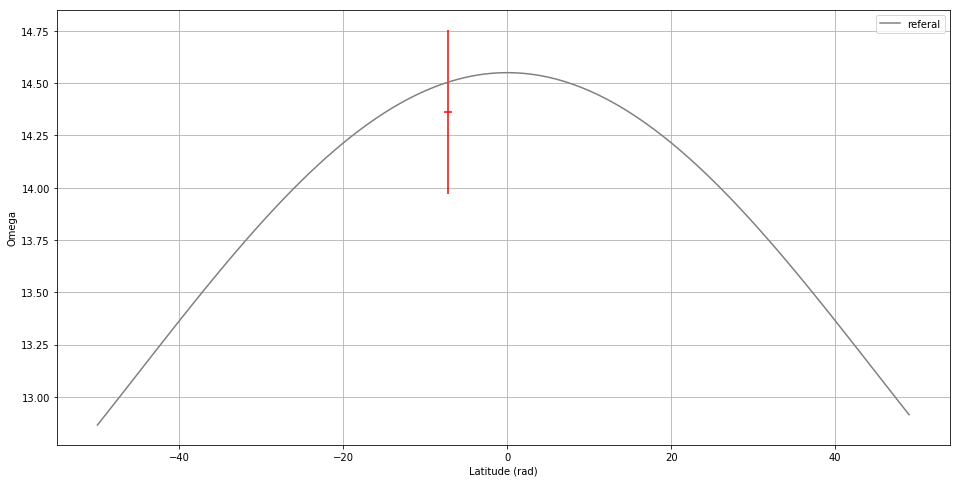

In [56]:
plt.figure(figsize=(16, 8))
plt.grid()
plt.xlabel('Latitude (rad)')
plt.ylabel('Omega')
plt.plot(ref_x*180/np.pi, ref_y*180/np.pi, label = 'referal', color = 'gray')
plt.errorbar(x = np.average(spot3_lat)*180/np.pi, y = np.average(omgsid3[:-1])*180/np.pi, xerr = np.std(spot3_lat)*180/np.pi, yerr = np.std(omgsid3[:-1])*180/np.pi, color = 'red')
plt.legend()
plt.show()

<b>The obtained data are close to the previously obtained values, however, they have a rather large error.<br>Now let's take the same measurements, but for a different data set.

<b>Now consider <s>the full picture of the world</s> all three spots:

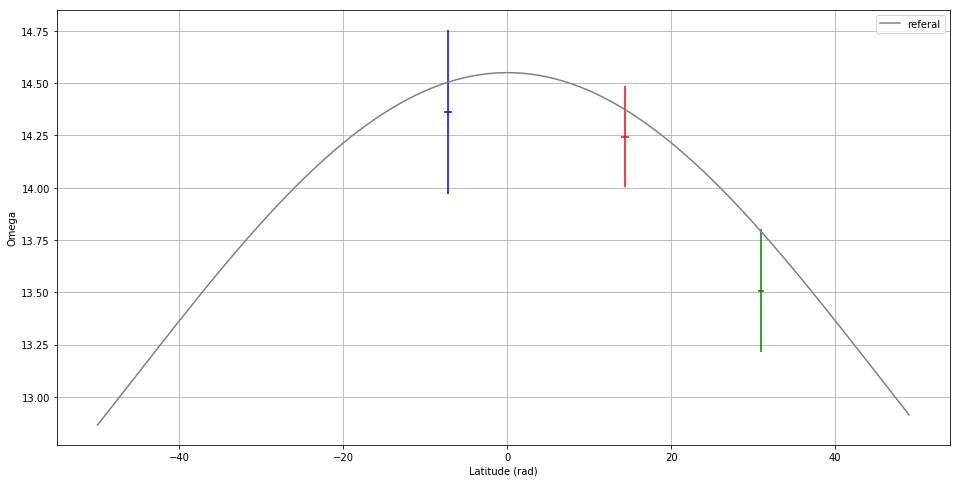

In [57]:
plt.figure(figsize=(16, 8))
plt.grid()
plt.xlabel('Latitude (rad)')
plt.ylabel('Omega')
plt.plot(ref_x*180/np.pi, ref_y*180/np.pi, label = 'referal', color = 'gray')
plt.errorbar(x = np.average(spot3_lat)*180/np.pi, y = np.average(omgsid3[:-1])*180/np.pi, xerr = np.std(spot3_lat)*180/np.pi, yerr = np.std(omgsid3[:-1])*180/np.pi, color = 'blue')
plt.errorbar(x = np.average(spot1_lat)*180/np.pi, y = np.average(omgsid1)*180/np.pi, xerr = np.std(spot1_lat)*180/np.pi, yerr = np.std(omgsid1)*180/np.pi, color = 'red')
plt.errorbar(x = np.average(spot2_lat)*180/np.pi, y = np.average(omgsid2)*180/np.pi, xerr = np.std(spot2_lat)*180/np.pi, yerr = np.std(omgsid2)*180/np.pi, color = 'green')
plt.legend()
plt.show()